In [ ]:
# https://www.youtube.com/watch?v=QIUxPv5PJOY&t=647s 
# Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM)
#               to predict the closing stock price of a corporation (Apple Inc.) using the past 60 day stock price.

In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [17]:
# Get the stock quote
df = yf.Ticker('AAPL').history(start='2012-01-01', end='2019-12-18')
# Get the number of rows and columns in the data set
df.shape

(2003, 7)

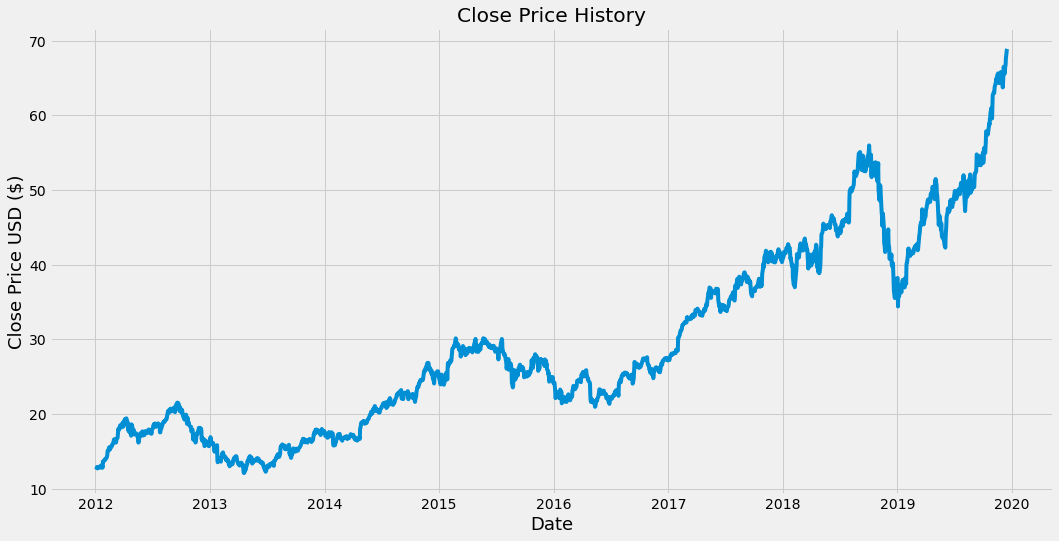

In [18]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [19]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

1603

In [20]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00803159],
       [0.00921998],
       [0.01168822],
       ...,
       [0.97724387],
       [0.9976202 ],
       [1.        ]])

In [21]:
num_timestamp = 60
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0: training_data_len, :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(num_timestamp, len(train_data)):
    x_train.append(train_data[i-num_timestamp:i, 0])
    y_train.append(train_data[i, 0])
    if i <= num_timestamp:
        print(x_train)
        print(y_train)
        print()

[array([0.00803159, 0.00921998, 0.01168822, 0.0140382 , 0.01367791,
       0.01448986, 0.01411886, 0.01349504, 0.01264544, 0.01527502,
       0.01764645, 0.01691513, 0.01290887, 0.01673227, 0.01296806,
       0.02708385, 0.02599226, 0.02741726, 0.03049854, 0.03236453,
       0.03220859, 0.03163321, 0.03408536, 0.0363922 , 0.03900573,
       0.04322698, 0.05209436, 0.05222889, 0.05716529, 0.06085415,
       0.05451434, 0.05695561, 0.05690711, 0.06375278, 0.06277939,
       0.06458092, 0.0678181 , 0.06961954, 0.07480868, 0.07858909,
       0.07968071, 0.08006258, 0.07359876, 0.07203938, 0.07227057,
       0.07834722, 0.08005717, 0.08372992, 0.09238773, 0.10393841,
       0.10177663, 0.1017819 , 0.11013329, 0.1127467 , 0.11088604,
       0.1091868 , 0.10741756, 0.1132951 , 0.11732829, 0.11901678])]
[0.11484388948365526]



In [22]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [23]:
x_train.shape

(1543, 60)

In [24]:
num_features = 1
# Reshape the data
# LSTM expect the input to be 3-D in the form of (# of samples, timestamp, # of features)
# x_train = np.reshape(x_train, (1543, 60, 1))
x_train = np.reshape(x_train, (len(train_data) - num_timestamp, num_timestamp, num_features))
x_train.shape

(1543, 60, 1)

In [25]:
# Build the LSTM model
model = Sequential()
# Add first layer, return_sequences=True because gonna use another LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(num_timestamp,1))) 
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [26]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1543/1543 [==============================] - 13s 9ms/step - loss: 6.6682e-04


In [28]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len: , :]

for i in range(num_timestamp, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

In [31]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_features))

In [32]:
# Get the model predicted price values
predictions = model.predict(x_test)
# Unscaling the value
predictions = scaler.inverse_transform(predictions)

In [33]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.14917593955993652

<ipython-input-36-4de4dd10a5cd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


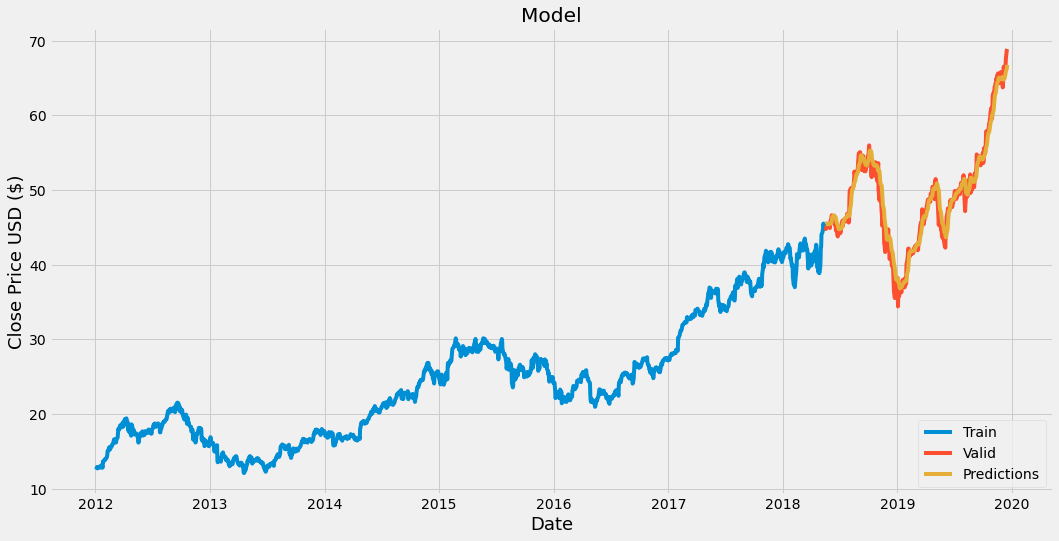

In [36]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [37]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-05-17,44.942200,45.540707
2018-05-18,44.778763,45.553692
2018-05-21,45.096024,45.498173
2018-05-22,44.983059,45.456520
2018-05-23,45.271465,45.411427
...,...,...
2019-12-11,66.519089,65.363762
2019-12-12,66.688614,65.618217
2019-12-13,67.595108,65.885574


In [41]:
# Get the quote
apple_quote = yf.Ticker('AAPL').history(start='2012-01-01', end='2019-12-17')
# Create a new dataframe
new_df = apple_quote.filter(['Close'])
# Get the last 60 day closing price and convert the dataframe to an array
last_60_days = new_df[-60:].values
# Scale the data to be values between 0 and 1 
last_60_days_scaled = scaler.transform(last_60_days)
# Create an empty list
X_test = []
# Append the past 60 days
X_test.append(last_60_days_scaled)
# Convert the X_test data set to a numpy array
X_test = np.array(X_test)
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(f'Apple price on 2019-12-18: {pred_price}')

Apple price on 2019-12-18: [[66.75754]]


In [43]:
yf.Ticker('AAPL').history(start='2019-12-18', end='2019-12-18')['Close']

Date
2019-12-17    68.887314
Name: Close, dtype: float64